# physionet2012 데이터 전처리
- 데이터 가져오기
- scaler 가져오기
- X, y 분리하기
- scaler 적용하기
- model에 입력가능한 3차원 형태 데이터 만들기
- (batch_size, maxlen, feature_dim)

In [1]:
# 전처리된 데이터 가져오기

import numpy as np
import pandas as pd

path = '/Users/jsha/gjai/final_project/black_swan_physionet/'
file = 'train_done_preprocessing.csv'
file2 = 'valid_done_preprocessing.csv'
file3 = 'test_done_preprocessing.csv'

train_df = pd.read_csv(path+file)
valid_df = pd.read_csv(path+file2)
test_df = pd.read_csv(path+file3)

maxlen = len(train_df[train_df['pid'] == train_df['pid'][0]])

In [2]:
len(train_df.columns)

46

In [3]:
# labels 컬럼 인덱스 찾기
inx = test_df.columns.get_indexer(['labels'])
print(inx)

# X, y 분리
y_train = train_df['labels']
X_train_nonorm = train_df.drop(columns=['pid', 'Gender', 'survival', 'surv_los', 'LOS', 'labels'])
print(y_train.shape)
print(X_train_nonorm.shape)

y_valid = valid_df['labels']
X_valid_nonorm = valid_df.drop(columns=['pid', 'Gender', 'survival', 'surv_los', 'LOS', 'labels'])
print(y_valid.shape)
print(X_valid_nonorm.shape)

y_test = test_df['labels']
X_test_nonorm = test_df.drop(columns=['pid', 'Gender', 'survival', 'surv_los', 'LOS', 'labels'])
print(y_test.shape)
print(X_test_nonorm.shape)

[41]
(226800,)
(226800, 40)
(25200,)
(25200, 40)
(28000,)
(28000, 40)


In [4]:
# scaler를 이용한 정규화

import pickle

mms = 'mms.pickle'
with open(path+mms, 'rb') as handler:
    load_mms = pickle.load(handler)
    
X_train = load_mms.transform(X_train_nonorm)
X_valid = load_mms.transform(X_valid_nonorm)
X_test = load_mms.transform(X_test_nonorm)

print(X_train.shape)
print(y_train.shape)
X_train_3d = X_train.reshape((-1, maxlen, X_train.shape[-1]))
print(X_train_3d.shape)
y_train_3d = y_train[::maxlen]
print(y_train_3d.shape)

X_valid_3d = X_valid.reshape((-1, maxlen, X_valid.shape[-1]))
print(X_valid_3d.shape)
y_valid_3d = y_valid[::maxlen]
print(y_valid_3d.shape)

X_test_3d = X_test.reshape((-1, maxlen, X_test.shape[-1]))
print(X_test_3d.shape)
y_test_3d = y_test[::maxlen]
print(y_test_3d.shape)

(226800, 40)
(226800,)
(3240, 70, 40)
(3240,)
(360, 70, 40)
(360,)
(400, 70, 40)
(400,)


# Functional API Model설계 

## cnn_bidirec_model

In [39]:
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, Dropout, Flatten, Bidirectional, Input, Concatenate

max_len = len(X_train_3d[0])
feature_dim = X_train_3d.shape[-1]

inp = Input(shape=(max_len, feature_dim))

cnn_hidden = Conv1D(filters=32, kernel_size=4, activation='relu', padding='same')(inp)
cnn_hidden = Dropout(0.2)(cnn_hidden)
cnn_hidden = Conv1D(filters=32, kernel_size=2, activation='relu', padding='same')(cnn_hidden)
cnn_hidden = Dropout(0.2)(cnn_hidden)
cnn_hidden = Dense(64, activation='relu')(cnn_hidden)

bidirec_hidden = Bidirectional(LSTM(32, activation='tanh', return_sequences=True))(inp)
bidirec_hidden = Dropout(0.2)(bidirec_hidden)
bidirec_hidden = Bidirectional(LSTM(32, activation='tanh', return_sequences=True))(bidirec_hidden)
bidirec_hidden = Dropout(0.2)(bidirec_hidden)
bidirec_hidden = Dense(64, activation='relu')(bidirec_hidden)

# hidden = Concatenate()([cnn_hidden, bidirec_hidden]) # 1. 기본모델. concat. feature를 늘리는 형태
# hidden = cnn_hidden + bidirec_hidden                   # 2. 변형모델1. sum 모델
# hidden = cnn_hidden * bidirec_hidden                     # 3. 변형모델2. multiply 모델
hidden = (cnn_hidden + bidirec_hidden) / 2                 # 4. 변형모델3. mean 모델
print(hidden.shape)

hidden = Dropout(0.5)(hidden)
hidden = Flatten()(hidden)
# print(hidden.shape)
hidden = Dense(128, activation='relu')(hidden)
hidden = Dropout(0.5)(hidden)
hidden = Dense(64, activation='relu')(hidden)
hidden = Dropout(0.5)(hidden)
hidden = Dense(32, activation='relu')(hidden)
hidden = Dropout(0.5)(hidden)
hidden = Dense(8, activation='relu')(hidden)
outp = Dense(1, activation='sigmoid')(hidden)

api_model = Model(inputs=[inp], outputs=[outp])

(None, 70, 64)


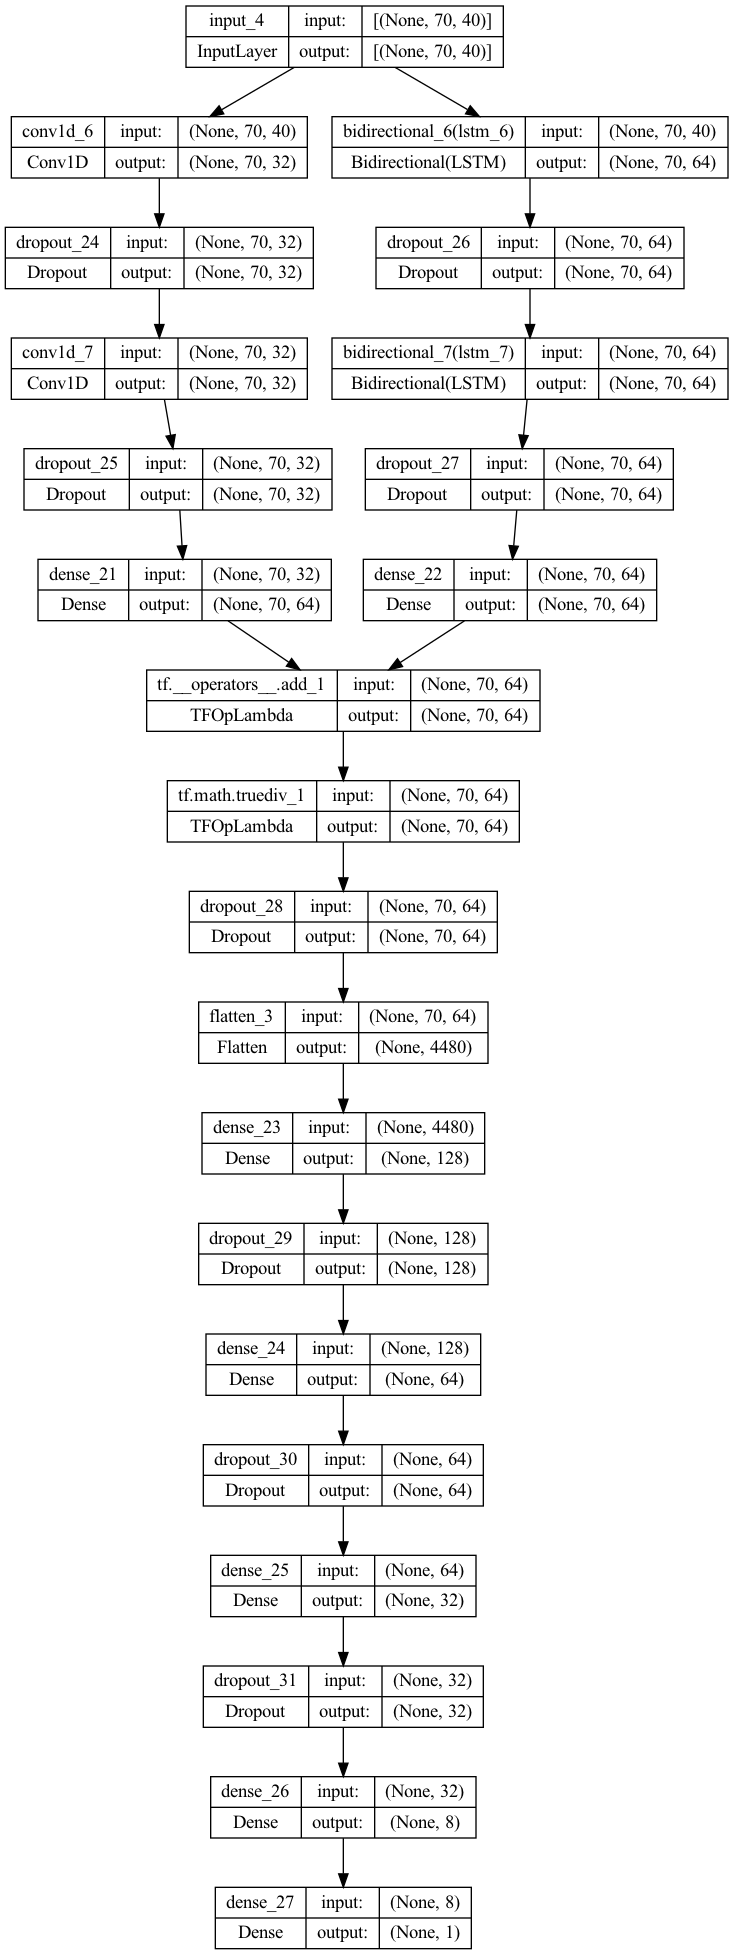

In [40]:
from keras.utils import plot_model

plot_model(api_model, show_shapes=True)

In [41]:
api_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 70, 40)]     0           []                               
                                                                                                  
 conv1d_6 (Conv1D)              (None, 70, 32)       5152        ['input_4[0][0]']                
                                                                                                  
 bidirectional_6 (Bidirectional  (None, 70, 64)      18688       ['input_4[0][0]']                
 )                                                                                                
                                                                                                  
 dropout_24 (Dropout)           (None, 70, 32)       0           ['conv1d_6[0][0]']         

In [42]:
api_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', 'AUC'])

In [43]:
# 모델 학습하기

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

epochs = 20
batch_size = 40
model_name = 'chp_api1_model.h5'

early_stopping = EarlyStopping(monitor='val_auc', patience=4, verbose=1)
checkpoint = ModelCheckpoint(path+model_name, monitor='val_auc', save_best_only=True)

history = api_model.fit(X_train_3d, y_train_3d, epochs=epochs, batch_size=batch_size, 
                    validation_data=(X_valid_3d, y_valid_3d), callbacks=[early_stopping, checkpoint])


Epoch 1/20
81/81 [==============================] - 9s 62ms/step - loss: 0.4846 - acc: 0.8102 - auc: 0.5450 - val_loss: 0.3653 - val_acc: 0.8639 - val_auc: 0.7706
Epoch 2/20
81/81 [==============================] - 4s 44ms/step - loss: 0.3938 - acc: 0.8670 - auc: 0.6671 - val_loss: 0.3712 - val_acc: 0.8639 - val_auc: 0.8054
Epoch 3/20
81/81 [==============================] - 4s 45ms/step - loss: 0.3741 - acc: 0.8673 - auc: 0.7184 - val_loss: 0.3763 - val_acc: 0.8639 - val_auc: 0.8147
Epoch 4/20
81/81 [==============================] - 4s 45ms/step - loss: 0.3629 - acc: 0.8682 - auc: 0.7300 - val_loss: 0.3219 - val_acc: 0.8639 - val_auc: 0.8075
Epoch 5/20
81/81 [==============================] - 4s 45ms/step - loss: 0.3537 - acc: 0.8682 - auc: 0.7561 - val_loss: 0.3151 - val_acc: 0.8639 - val_auc: 0.8228
Epoch 6/20
81/81 [==============================] - 4s 46ms/step - loss: 0.3423 - acc: 0.8676 - auc: 0.7693 - val_loss: 0.3856 - val_acc: 0.8639 - val_auc: 0.8069
Epoch 7/20
81/81 [====

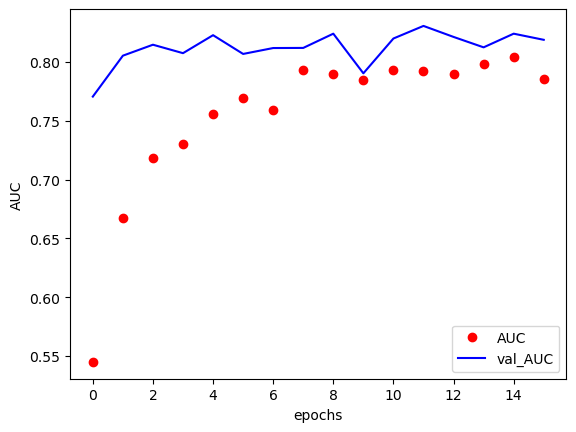

In [44]:
# epoch별 model acc 비교하기 

import matplotlib.pyplot as plt

history = history.history

loss = history['loss']
acc = history['acc']
auc = history['auc']
val_loss = history['val_loss']
val_acc = history['val_acc']
val_auc = history['val_auc']
length = len(val_loss)

plt.plot(range(length), auc, 'ro', label='AUC')
plt.plot(range(length), val_auc, 'b-', label='val_AUC')
plt.xlabel('epochs')
plt.ylabel('AUC')
plt.legend()

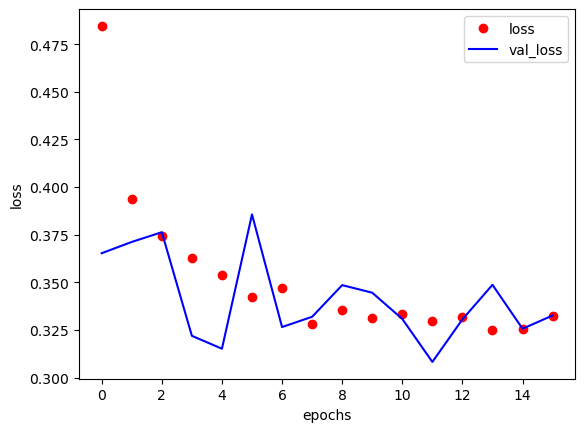

In [45]:
# epoch별 모델 loss 확인하기

plt.plot(range(length), loss, 'ro', label='loss')
plt.plot(range(length), val_loss, 'b-', label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [46]:
# test loss, acc, auc 구하기1
test_loss, test_acc, test_auc = api_model.evaluate(X_test_3d, y_test_3d)
print(f'test_acc: {test_acc:.4f}')
print(f'test_auc: {test_auc:.4f}')


# auroc 구하기2
from sklearn.metrics import roc_auc_score

test_pred = api_model.predict(X_test_3d)
auc = roc_auc_score(y_test_3d, test_pred)

print(f'acc_test: {test_acc:.4f}')
print(f'auc_score_test: {auc:.4f}')

13/13 [==============================] - 2s 13ms/step - loss: 0.3185 - acc: 0.8700 - auc: 0.8208
test_acc: 0.8700
test_auc: 0.8208
13/13 [==============================] - 2s 13ms/step
acc_test: 0.8700
auc_score_test: 0.8207


In [47]:
file_name = 'api_model_best_upto.h5'
api_model.save(path + file_name)

In [48]:
from keras.models import load_model
from sklearn.metrics import roc_auc_score

loaded_model = load_model(path + file_name)

test_loss, test_acc, test_auc = loaded_model.evaluate(X_test_3d, y_test_3d)
test_pred = loaded_model.predict(X_test_3d)
auc = roc_auc_score(y_test_3d, test_pred)

print(f'acc_test: {test_acc:.4f}')
print(f'auc_score_test: {auc:.4f}')

13/13 [==============================] - 1s 13ms/step
acc_test: 0.8700
auc_score_test: 0.8207


## 결과 정리
- 결과가 그렇게 나쁘지 않음.
- 결합할 때, max, min, sum, mean 으로 계산하여 넣어보자.

### 기본 모델 - just concatenate()
 - acc_test: 0.8700
 - auc_score_test: 0.8313

### 변형 모델1 - concat using sum
- acc_test: 0.8700
- auc_score_test: 0.8202

### 변형 모델2 - multiply
- acc_test: 0.8700
- auc_score_test: 0.8218

### 변형 모델3 - mean
- acc_test: 0.8700
- auc_score_test: 0.8207